In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from utils import *


#### Working at GT ####

USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/version-002-p04
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [17]:
stay_awake(180)

0 min -> 3 min -> 6 min -> 9 min -> 12 min -> 15 min -> 18 min -> 21 min -> 24 min -> 27 min -> 

KeyboardInterrupt: 

In [3]:
# load all-in-one df
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_healpix_nside64.pkl")

In [4]:
df.head()

,grb_name,grb_name_GBM,ra,dec,mjd_start,t100,t90,gbm,source_uncertainty,redshift,t_center,hasHealpix,probs
0,GRB190613B,GRB190613449,305.431917,-4.646667,58647.449285,0.001905,0.000056,0,0.000056,NaN,58647.450238,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,GRB190613A,GRB190613172,182.529208,67.235278,58647.171736,0.000204,0.000198,0,0.000056,NaN,58647.171838,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,GRB190612A,GRB190612165,223.950000,62.100000,58646.164836,0.001677,0.001677,1,7.025096,NaN,58646.165675,True,"[1.8016500009675246e-06, 2.0288993030385598e-0..."
3,GRB190611B,GRB190611950,84.758333,50.833333,58645.949833,0.001217,0.001164,0,5.900000,NaN,58645.950442,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,GRB190611A,None,324.722625,-56.074278,58645.742373,0.000484,0.000484,0,0.000194,NaN,58645.742615,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# GRB List

## t100 distribution

In [5]:
hl.hist(df.t100*86400.
         ,bins=np.r_[np.logspace(np.log10(0.001), np.log10(2.5), 20, endpoint=False), np.logspace(np.log10(2.5), np.log10(10000), 20)])

Hist(39 bins in [0.001,10000.0], with sum 2051.0, 10 empty bins, and 0 non-finite values)

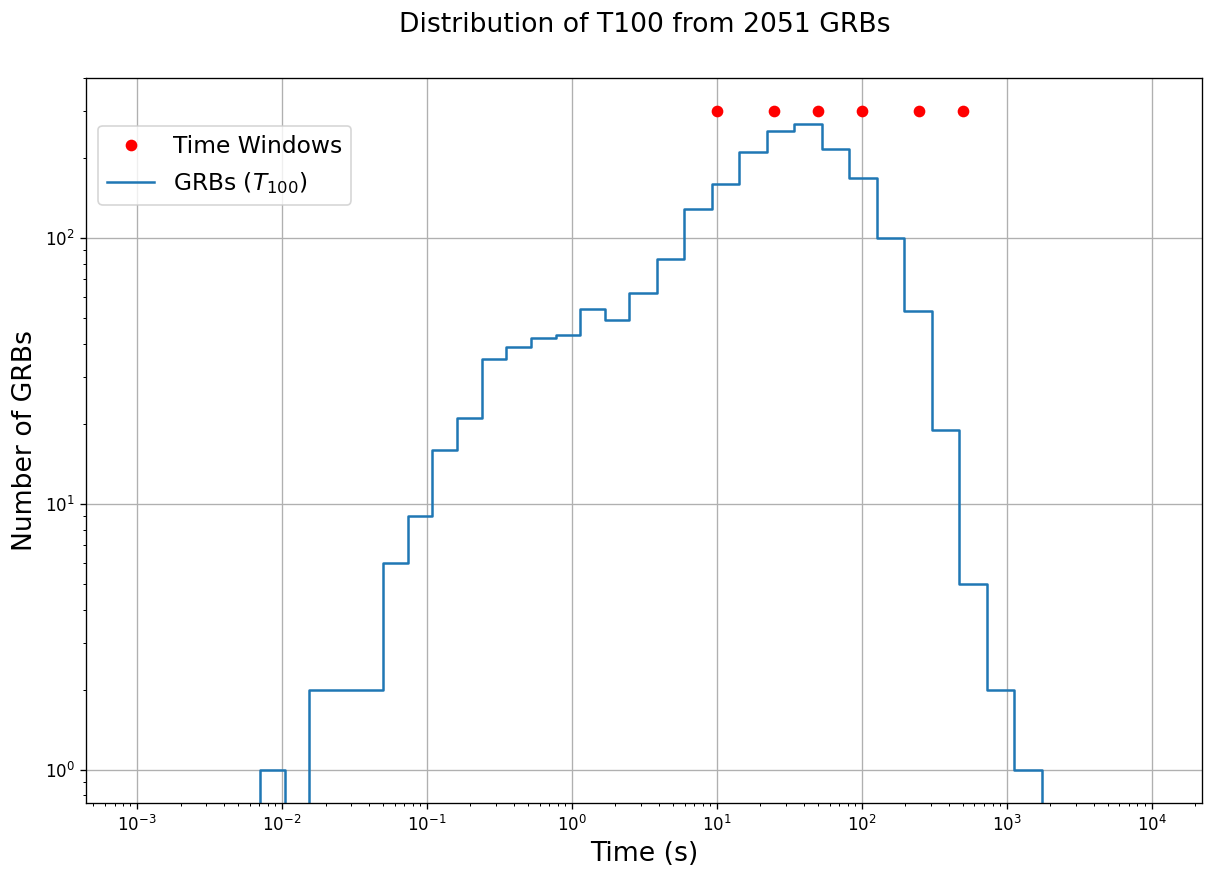

In [19]:
fig, ax = plt.subplots(figsize=(12,8), dpi=120)

h = hl.hist (df.t100*86400.
             ,bins=np.r_[
                 np.logspace(np.log10(0.001), np.log10(2.5), 20, endpoint=False), 
                 np.logspace(np.log10(2.5), np.log10(10000), 20)
             ])
hl.plot1d (ax, h, label=r'GRBs ($T_{100}$)')

ax.plot([10,25,50,100,250,500], np.ones(6)+300, 'ro', label="Time Windows")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Number of GRBs', fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=14)
ax.set_title('Distribution of T100 from {} GRBs'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

## angular and spatial separation

In [7]:
"""
grb_pairs = []
mjd_separation = []
angular_separation = []
with time('get separation'):
    for i in df.index[:]:
        if i % 10 == 0: print("i: ", i)
        for j in df.index[i+1:]:
            grb_pair = set([df.grb_name[i], df.grb_name[j]])
            mjd_diff = abs(df['mjd_start'][i] - df['mjd_start'][j])
            ang_diff = cy.coord.delta_angle(
                np.deg2rad(df.dec[i])
                , np.deg2rad(df.ra[i])
                , np.deg2rad(df.dec[j])
                , np.deg2rad(df.ra[j])
                , latlon=True)
            grb_pairs.append(grb_pair)
            mjd_separation.append(mjd_diff)
            angular_separation.append(np.rad2deg(ang_diff))
grb_pairs = np.array(grb_pairs)
mjd_separation = np.array(mjd_separation)
angular_separation = np.array(angular_separation)
separation_df = pd.DataFrame({
    'grb_pair': grb_pairs, 
    'mjd_diff': mjd_separation, 
    'angular_diff': angular_separation
})
separation_df.to_pickle(DATA_DIR+"/plot/Proximities.pkl")
"""

'\ngrb_pairs = []\nmjd_separation = []\nangular_separation = []\nwith time(\'get separation\'):\n    for i in df.index[:]:\n        if i % 10 == 0: print("i: ", i)\n        for j in df.index[i+1:]:\n            grb_pair = set([df.grb_name[i], df.grb_name[j]])\n            mjd_diff = abs(df[\'mjd_start\'][i] - df[\'mjd_start\'][j])\n            ang_diff = cy.coord.delta_angle(\n                np.deg2rad(df.dec[i])\n                , np.deg2rad(df.ra[i])\n                , np.deg2rad(df.dec[j])\n                , np.deg2rad(df.ra[j])\n                , latlon=True)\n            grb_pairs.append(grb_pair)\n            mjd_separation.append(mjd_diff)\n            angular_separation.append(np.rad2deg(ang_diff))\ngrb_pairs = np.array(grb_pairs)\nmjd_separation = np.array(mjd_separation)\nangular_separation = np.array(angular_separation)\nseparation_df = pd.DataFrame({\n    \'grb_pair\': grb_pairs, \n    \'mjd_diff\': mjd_separation, \n    \'angular_diff\': angular_separation\n})\nseparation

In [8]:
separation_df = pd.read_pickle(DATA_DIR+"/plot/Proximities.pkl")
separation_df['mjd_diff_seconds'] = separation_df["mjd_diff"] * 86400.
separation_df.head()

,grb_pair,mjd_diff,angular_diff,mjd_diff_seconds
0,"{GRB190613B, GRB190613A}",0.277549,106.511325,23980.257
1,"{GRB190612A, GRB190613B}",1.284449,90.143918,110976.425
2,"{GRB190611B, GRB190613B}",1.499452,122.700338,129552.658
3,"{GRB190611A, GRB190613B}",1.706913,53.681731,147477.257
4,"{GRB190613B, GRB190610C}",2.615705,14.577721,225996.876


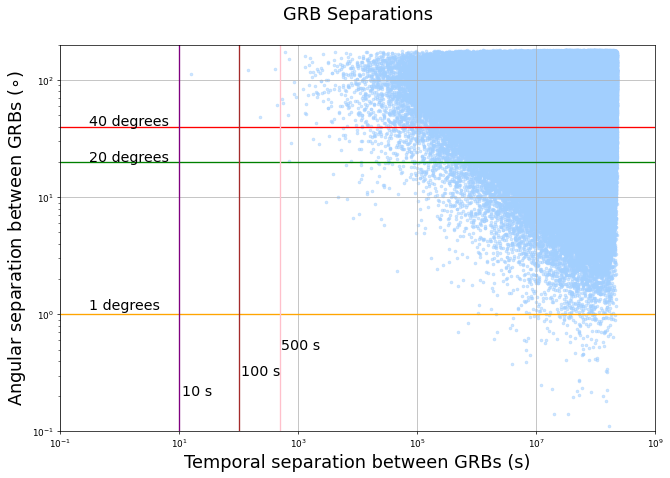

In [9]:
fig, ax = plt.subplots(figsize=(12,8), dpi=64)

ax.scatter(separation_df['mjd_diff_seconds']
           , separation_df['angular_diff']
           , c="#a2cffe"
           , marker='.'
           , alpha = 0.5)

ax.axhline(1,color = 'orange')
ax.text(0.3, 1.1, '1 degrees', fontsize=16)
ax.axhline(20,color = 'green')
ax.text(0.3, 20.1, '20 degrees', fontsize=16)
ax.axhline(40,color = 'red')
ax.text(0.3, 41, '40 degrees', fontsize=16)

ax.axvline(10, color = 'purple')
ax.text(11, .2, '10 s', fontsize=16)
ax.axvline(100, color = 'brown')
ax.text(110, .3, '100 s', fontsize=16)
ax.axvline(500, color = 'pink')
ax.text(510, .5, '500 s', fontsize=16)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Temporal separation between GRBs (s)', fontsize=20)
ax.set_ylabel(r'Angular separation between GRBs ($\circ$)', fontsize=20)
ax.set_xlim(1e-1,1e9)
ax.set_ylim(1e-1,2e2)
ax.grid(True)
# ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=16)
ax.set_title('GRB Separations', fontsize=20, y=1.05)
plt.show()

# Healpix Map

## real healpix example: GRB180423A

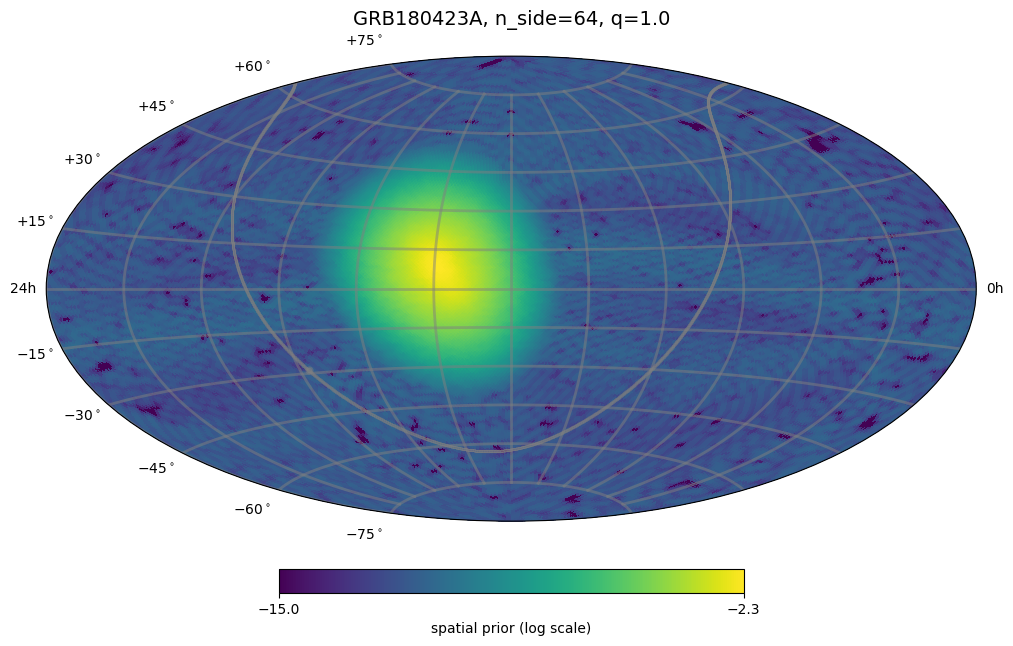

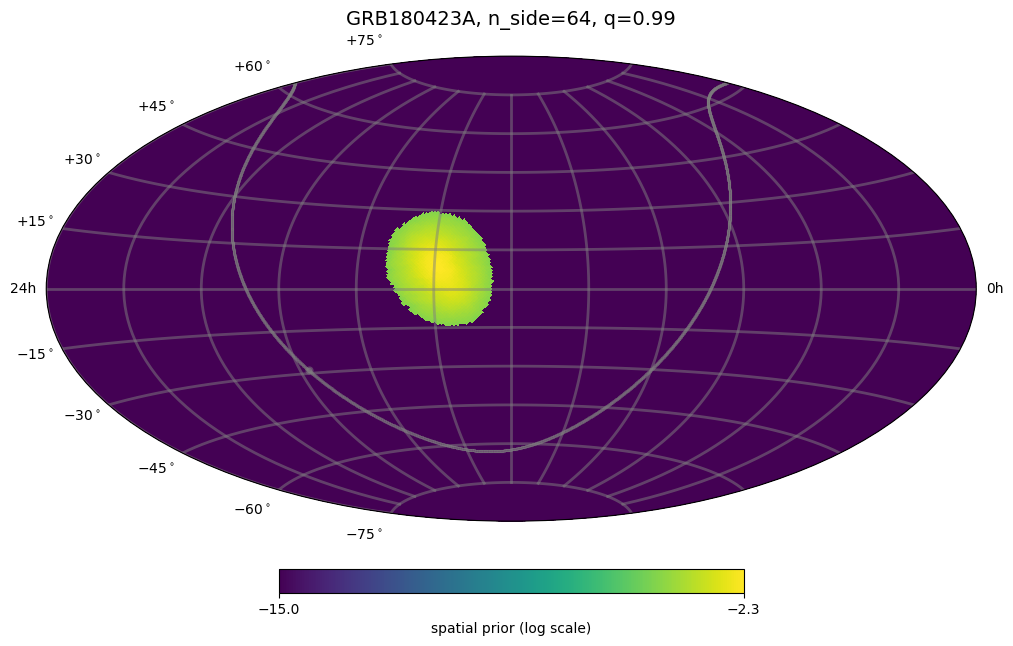

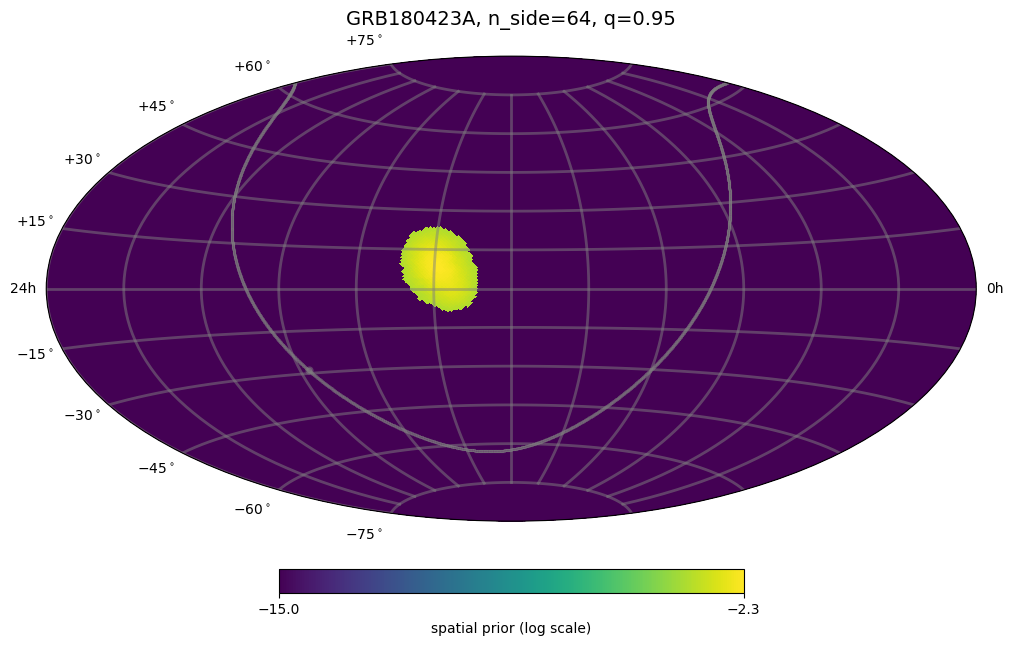

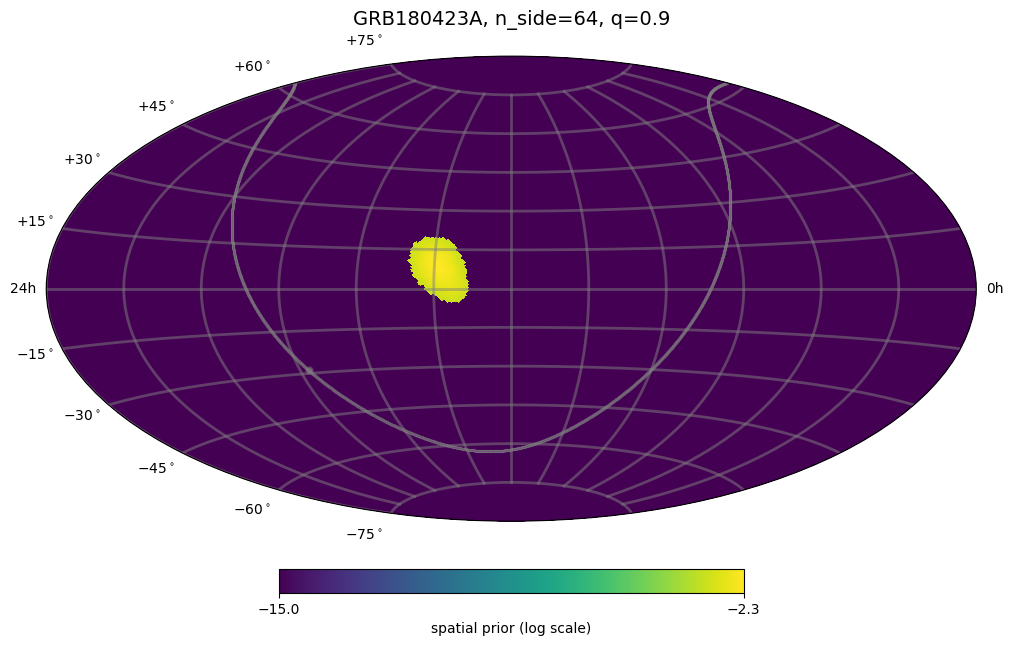

In [15]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
for q in [1.0, 0.99, 0.95, 0.90]:
    healpix[healpix <= isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(12,8), dpi=100,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-15)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'spatial prior (log scale)')
    ax.set_title("GRB180423A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()


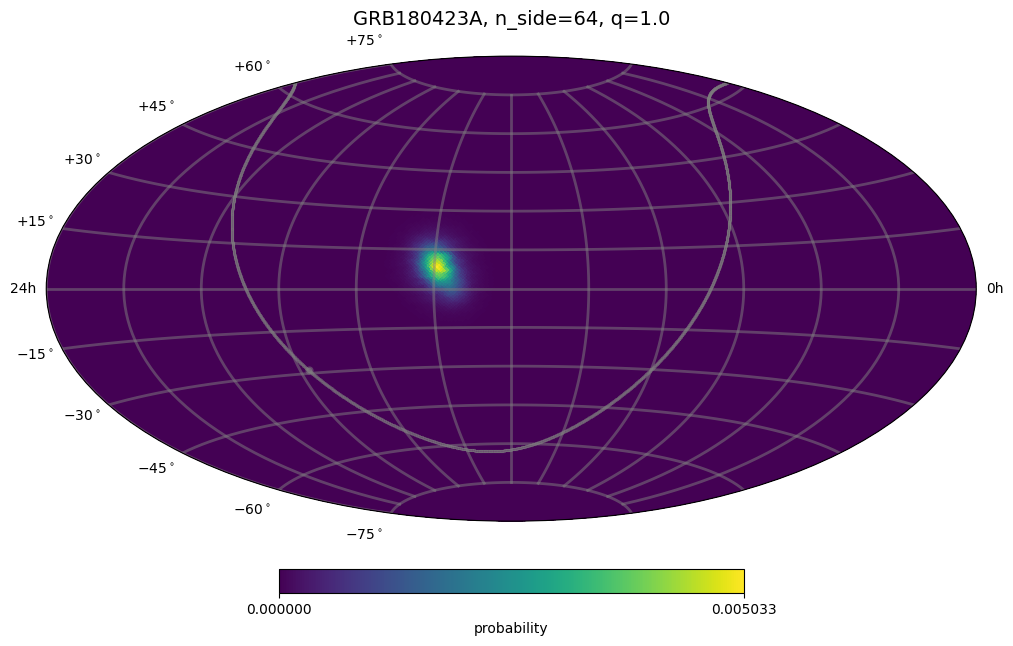

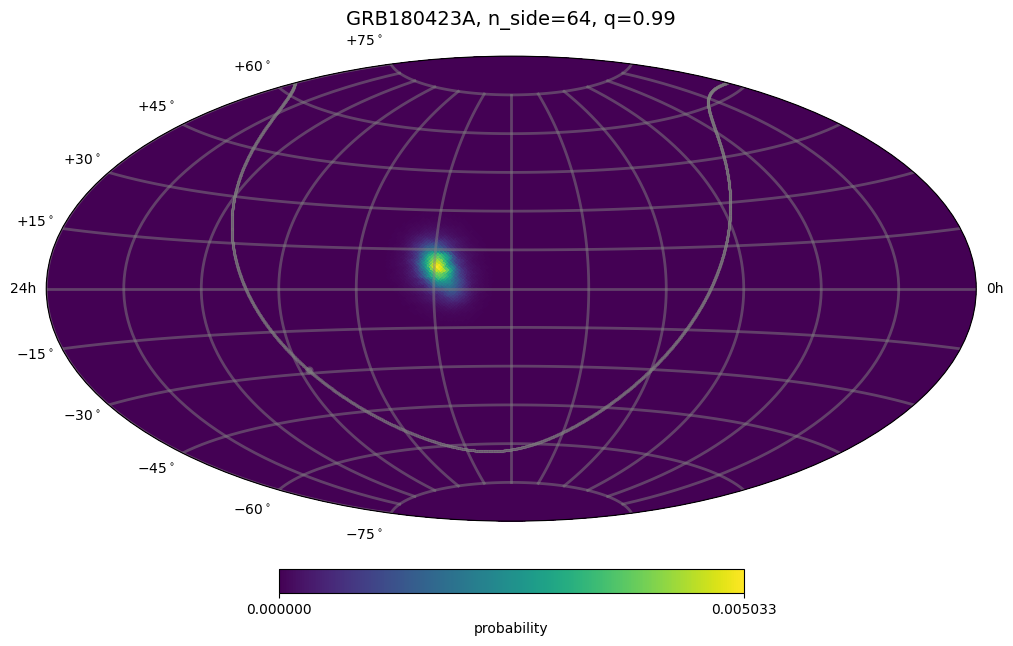

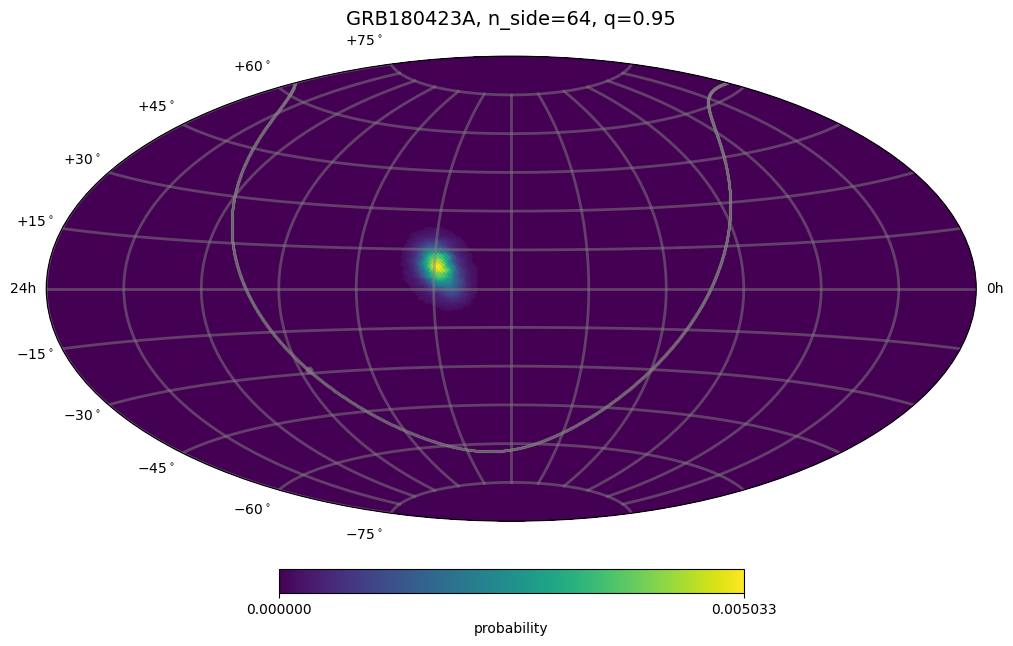

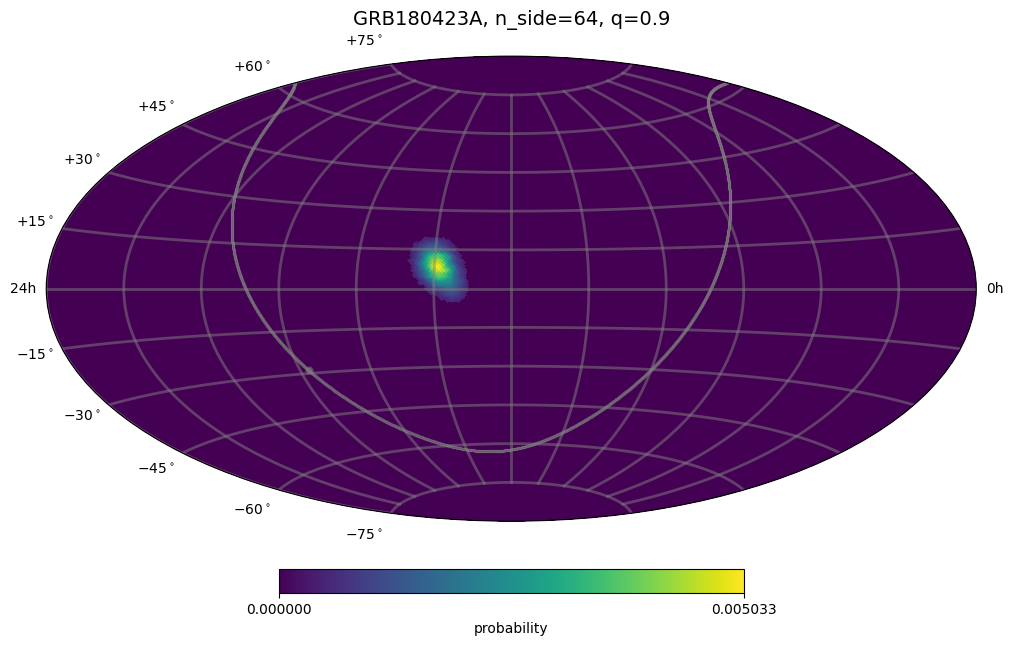

In [16]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
for q in [1.0, 0.99, 0.95, 0.90]:
    healpix[healpix <= isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(12,8), dpi=100,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'probability')
    ax.set_title("GRB180423A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()



# GRECO datasets

# Time windows

In [ ]:
t100_start_in_second = 0
t100_end_in_second = 

In [41]:
(58231.0332114- 58231.03258640) * 86400

54.00000005029142

Text(58231.0448989, 0.35, '$\\longleftarrow$"Prompt"')

<Figure size 432x288 with 0 Axes>

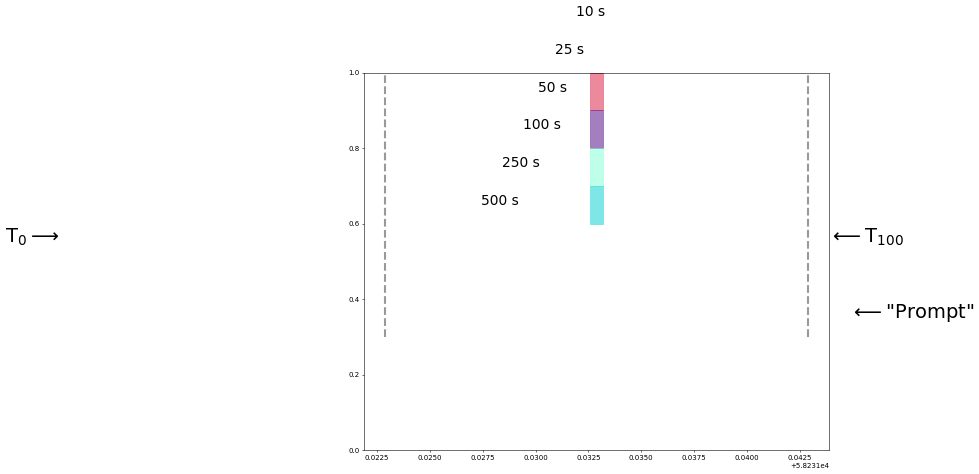

In [19]:
###
### Cartoon of time windows with T0 and T100 dashed lines
###
t100_start = 58231.03258640
t100_stop = 58231.0332114
t_center = start + (stop-start)/2
start = t100_start
stop = t100_stop
tw = [10., 25., 50., 100., 250., 500.]         # Seconds --> 200000., 2000000.
time_windows = [i/2./86400. for i in tw]
plt.figure()

ea = [0.001, 0.0015, 0.0018, 0.002, 0.0025, 0.003] # ea = extra adjustment
ea2 = [0., 0., 0., 0., 0., 0.] # ea2 = extra adjustment 2

true_time_windows = ['10 s', '25 s', '50 s', '100 s', '250 s', '500 s']
new_time_windows = time_windows
plot_time_windows = [i/86400. for i in new_time_windows]
color_list = ['thistle', 'violet', 'crimson', 'indigo', 'aquamarine',
          'darkturquoise',  'dodgerblue', 'mediumseagreen', 'yellowgreen', 'palegoldenrod','thistle', 'violet', 'crimson']
plt.figure(figsize=(12,10), dpi=50)
for i in range(len(plot_time_windows)):
    startTW = start-plot_time_windows[i]+ea2[i]
    stopTW = stop+plot_time_windows[i]
    center = (stopTW-startTW)/2.
    tw_duration = time_windows[i]*2. + (stop-start)
    plt.axvspan(startTW, stopTW, ymin=1.2-0.1*(i+1), ymax=1.2-0.1*(i), alpha=0.5, color=color_list[i])
    plt.text(startTW+center-0.0005*i-ea[i], 1.2-0.1*(i+0.5), true_time_windows[i], fontsize=20)

plt.axvline(t_center-0.01, 0.3, 1.2, linestyle='--', color='grey', alpha=0.8, linewidth=3)
plt.axvline(t_center+0.01, 0.3, 1.2, linestyle='--', color='grey', alpha=0.8, linewidth=3)
plt.text(t_center-0.028, 0.55, r'T$_{0}\longrightarrow$', fontsize=28)
plt.text(t_center+0.011, 0.55, r'$\longleftarrow$T$_{100}$', fontsize=28)
plt.text(t_center+0.012, 0.35, r'$\longleftarrow$"Prompt"', fontsize=28)

#plt.text(t_center-0.05, 0.82, 'IceCube \nPreliminary', color='r', fontsize=28)

# plt.xscale('log')
# plt.xlim(t_center-plot_time_windows[-1], t_center+plot_time_windows[-1])
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.yticks(np.r_[0:1.3:0.1], [])
# # plt.ylim(0, 1.2)
# plt.grid(True)
# plt.xlabel('Time Window', fontsize=20)
# plt.title('Size of Time Window', fontsize=28)